In [433]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from itertools import cycle
from scipy import interp

# Data Loading

In [395]:
train_raw = pd.read_csv('/home/tonzhu/Documents/Code/Kaggle/driver_prediction/data/train.csv')

In [396]:
test_raw = pd.read_csv('/home/tonzhu/Documents/Code/Kaggle/driver_prediction/data/test.csv')

In [397]:
train_raw.head(10)

id  target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
0   7       0          2              2          5              1   
1   9       0          1              1          7              0   
2  13       0          5              4          9              1   
3  16       0          0              1          2              0   
4  17       0          0              2          0              1   
5  19       0          5              1          4              0   
6  20       0          2              1          3              1   
7  22       0          5              1          4              0   
8  26       0          5              1          3              1   
9  28       1          1              1          2              0   

   ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin       ...        \
0              0              0              1              0       ...         
1              0              0              0              1       ...         
2              0              0              0              1       ...         
3              0              1              0              0       ...         
4              0              1              0              0       ...         
5              0              0              0              0       ...         
6              0              0              1              0       ...         
7              0              1              0              0       ...         
8              0              0              0              1       ...         
9              0              0              1              0       ...         

   ps_calc_11  ps_calc_12  ps_calc_13  ps_calc_14  ps_calc_15_bin  \
0           9           1           5           8               0   
1           3           1           1           9               0   
2           4           2           7           7               0   
3           2           2           4           9               0   
4           3           1           1           3               0   
5           4           2           0           9               0   
6           3           0           0          10               0   
7           7           1           3           6               1   
8           4           2           1           5               0   
9           3           5           0           6               0   

   ps_calc_16_bin  ps_calc_17_bin  ps_calc_18_bin  ps_calc_19_bin  \
0               1               1               0               0   
1               1               1               0               1   
2               1               1               0               1   
3               0               0               0               0   
4               0               0               1               1   
5               1               0               1               1   
6               1               0               0               1   
7               0               1               0               1   
8               1               0               0               0   
9               1               0               0               1   

   ps_calc_20_bin  
0               1  
1               0  
2               0  
3               0  
4               0  
5               1  
6               0  
7               0  
8               1  
9               0  

[10 rows x 59 columns]

# Data Preprocessing

In [398]:
# Mark binary, multi-class categorical and continuous variables
columns = list(train_raw.columns[2:])
for i in xrange(len(columns)):
    if 'bin' in columns[i]:
        columns[i] = 'bin_'+columns[i][:-4]
    elif 'cat' in columns[i]:
        columns[i] = 'cat_'+columns[i][:-4]
    else:
        columns[i] = 'con_'+columns[i]

In [399]:
train_raw.columns = ['id', 'target'] + columns
test_raw.columns = ['id'] + columns

In [400]:
train_raw.sort_index(axis = 1, inplace = True)
test_raw.sort_index(axis = 1, inplace = True)
Train_1 = train_raw.copy()
Test_1 = test_raw.copy()

In [401]:
# Count 3 types of variables
bin_count = 0  # 17
cat_count = 0  # 14
con_count = 0  # 26
columns_new = list(Train_1.columns[:-2])
i = 0
while i < len(columns_new):
    if 'bin' in columns_new[i]:
        bin_count += 1
    elif 'cat' in columns_new[i]:
        cat_count += 1
    elif 'con' in columns_new[i]:
        con_count += 1
    i += 1

In [402]:
# Create Risk Tables for categorical variables with high cardinality
# record the columns and indice of high cardinality categorical variables
# bin_count: bin_count + cat_count from columns_new
cat_risk = []
overall_risk_rate = sum(Train_1['target']) * 1.0 / len(Train_1)
def smoothedrisktable(df, i):
    risk_count = columns_new[i] + '_' + 'risk_count'
    df[risk_count] = df.groupby(columns_new[i])['target'].transform('sum')
    count = columns_new[i] + '_' + 'total_count'
    df[count] = df.groupby(columns_new[i])['target'].transform('count')
    ratio = columns_new[i] + '_' + 'ratio'
    df[ratio] = df[risk_count] / df[count]
    df.loc[df[columns_new[i]] == -1, ratio] = overall_risk_rate
    df[ratio] = (10 + 100 * df[ratio]) / (100 + 100)
    del df[count]
    del df[risk_count]
    # Save training risk tables
    tmp = df.groupby([columns_new[i], ratio])[columns_new[i], ratio].mean()
    tmp = tmp.reset_index(drop = True)
    cat_risk.append(tmp)
for i in xrange(bin_count, bin_count + cat_count):
    smoothedrisktable(Train_1, i)

In [404]:
# Merge Training risk tables with Test data
# bin_count: bin_count + cat_count from columns_new
for i in xrange(bin_count, bin_count + cat_count):
    Test_1 = Test_1.merge(cat_risk[i - bin_count], how = 'left', on = columns_new[i])

In [406]:
# delete original categorical variables
for i in xrange(bin_count, bin_count + cat_count):
    Train_1.drop([columns_new[i]], axis = 1, inplace = True)
for i in xrange(bin_count, bin_count + cat_count):
    Test_1.drop([columns_new[i]], axis = 1, inplace = True)

In [407]:
Train_1 = Train_1.sort_index(axis = 1)
Test_1 = Test_1.sort_index(axis = 1)

In [408]:
# Plug-in missing values with mean for continuous variables - Training Data
miss_list = [45, 46, 48, 56]
for i in miss_list:
    Train_1.loc[Train_1.iloc[:, i] == -1, Train_1.columns[i]] = np.nan
for i in miss_list:
    Train_1[Train_1.columns[i]].fillna(Train_1[Train_1.columns[i]].mean(skipna = True), inplace = True)

In [409]:
# Calculate and save mean and std for each continuous variable
train_mean = []
train_std = []
for i in xrange(31, 57):
    train_mean.append(Train_1[Train_1.columns[i]].mean())
    train_std.append(Train_1[Train_1.columns[i]].std())

In [410]:
# Plug-in missing values with mean for continuous variables - Test Data
miss_list_test = [45, 48, 56]
for i in miss_list_test:
    Test_1.loc[Test_1.iloc[:, i] == -1, Test_1.columns[i]] = np.nan
for i in miss_list:
    Test_1[Test_1.columns[i]].fillna(train_mean[i - 31], inplace = True)

In [413]:
Train_1.head()

bin_ps_calc_15  bin_ps_calc_16  bin_ps_calc_17  bin_ps_calc_18  \
0               0               1               1               0   
1               0               1               1               0   
2               0               1               1               0   
3               0               0               0               0   
4               0               0               0               1   

   bin_ps_calc_19  bin_ps_calc_20  bin_ps_ind_06  bin_ps_ind_07  \
0               0               1              0              1   
1               1               0              0              0   
2               1               0              0              0   
3               0               0              1              0   
4               1               0              1              0   

   bin_ps_ind_08  bin_ps_ind_09   ...    con_ps_car_15  con_ps_ind_01  \
0              0              0   ...         3.605551              2   
1              1              0   ...         2.449490              1   
2              1              0   ...         3.316625              5   
3              0              0   ...         2.000000              0   
4              0              0   ...         2.000000              0   

   con_ps_ind_03  con_ps_ind_14  con_ps_ind_15  con_ps_reg_01  con_ps_reg_02  \
0              5              0             11            0.7            0.2   
1              7              0              3            0.8            0.4   
2              9              0             12            0.0            0.0   
3              2              0              8            0.9            0.2   
4              0              0              9            0.7            0.6   

   con_ps_reg_03  id  target  
0       0.718070   7       0  
1       0.766078   9       0  
2       0.894047  13       0  
3       0.580948  16       0  
4       0.840759  17       0  

[5 rows x 59 columns]

# Modeling

In [429]:
# Define K-Fold Cross Validation 
def kfoldcvMethod(x,y):
    classifier = RandomForestClassifier(n_estimators = 100)
    cv = StratifiedKFold(n_splits = 10)
    fprs,tprs=[],[]
    auc=[]
    i=1
    for train, test in cv.split(x,y):
        pred = classifier.fit(x[train],y[train]).predict_proba(x[test])
        fpr,tpr,thr = metrics.roc_curve(y[test],pred[:,1])
        aucs = metrics.auc(fpr,tpr)
        plt.plot(fpr,tpr,label = "Fold %d AUC : %.3f" % (i,aucs))
        tprs.append(tpr)
        fprs.append(fpr)
        auc.append(aucs)    
        i+=1
    plt.plot([0,1],[0,1],'--r',label="random")    
    plt.legend(loc=4,prop={'size': 10})
    plt.title("ROC - Mean AUC %.3f" % np.mean(auc))
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.show()

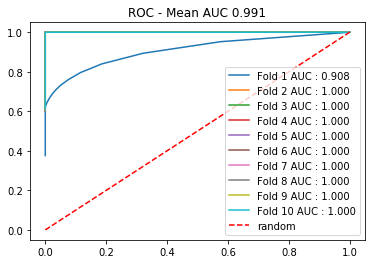

In [434]:
# Utilize SMOTE Upsampling method to handle imbalanced dataset
smot = SMOTE(kind='regular')
xsmote, ysmote = smot.fit_sample(Train_1.iloc[:,:-2].values, Train_1.iloc[:,-1].values)
kfoldcvMethod(xsmote, ysmote)

# Check variable correlation and missing percentage

Shape of Xtrain:  (595212, 57)


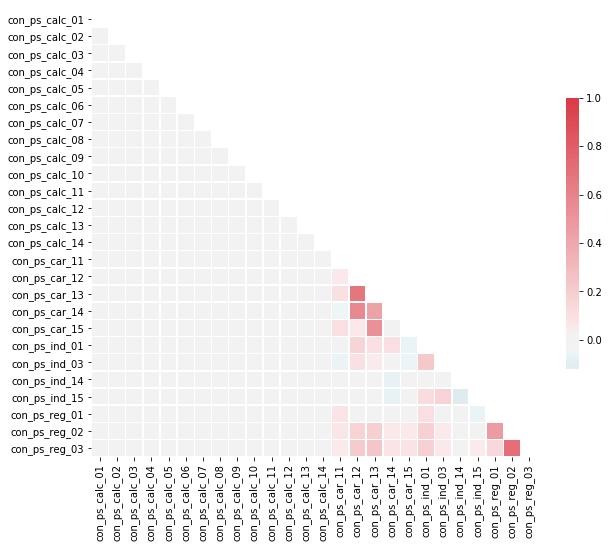

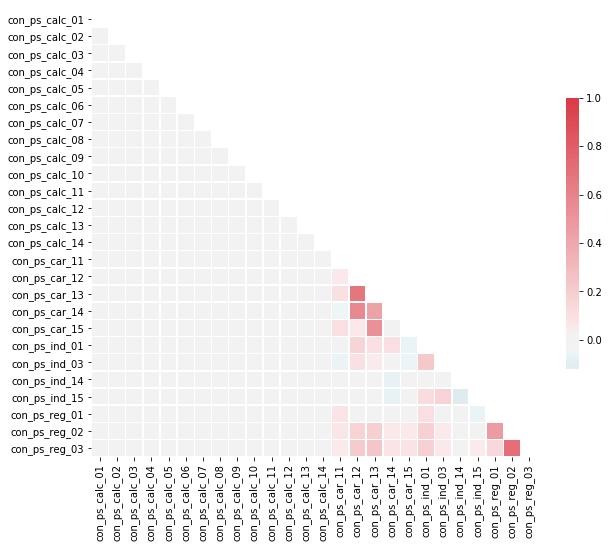

In [436]:
# Correlation Plot
Train_feature = Train_1.iloc[:,:-2]
print "Shape of Xtrain: ", Train_feature.shape
corr = Train_feature [filter(lambda x: 'bin' not in x and 'cat' not in x, Train_feature .columns)].corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [438]:
# Check missing proportion
# Get information of missing value on the entire train set
def missingvalueinfo(df):
    nrows,ncols = df.shape
    for i in df.columns[2:]:
        try:
            miss_rate = df[df[i] == -1].shape[0] * 100.0 / nrows
            if miss_rate > 0:
                print("Missing values rate in columns {} : {}% and count : {}".format(i,round(miss_rate, 2),df[df[i] == -1].shape[0]))
        except e:
            print e

print "For Train:"
missingvalueinfo(train_raw)

# print "For Test:"
# missingvalueinfo(df_test)

For Train:
Missing values rate in columns cat_ps_car_01 : 0.02% and count : 107
Missing values rate in columns cat_ps_car_02 : 0.0% and count : 5
Missing values rate in columns cat_ps_car_03 : 69.09% and count : 411231
Missing values rate in columns cat_ps_car_05 : 44.78% and count : 266551
Missing values rate in columns cat_ps_car_07 : 1.93% and count : 11489
Missing values rate in columns cat_ps_car_09 : 0.1% and count : 569
Missing values rate in columns cat_ps_ind_02 : 0.04% and count : 216
Missing values rate in columns cat_ps_ind_04 : 0.01% and count : 83
Missing values rate in columns cat_ps_ind_05 : 0.98% and count : 5809
Missing values rate in columns con_ps_car_11 : 0.0% and count : 5
Missing values rate in columns con_ps_car_12 : 0.0% and count : 1
Missing values rate in columns con_ps_car_14 : 7.16% and count : 42620
Missing values rate in columns con_ps_reg_03 : 18.11% and count : 107772


In [439]:
# Extract PCA for training
# Normalization for 
for i in xrange(31, 57):
    Train_1.iloc[:,i] = (Train_1.iloc[:,i] - train_mean[i - 31]) / train_std[i - 31]
for i in xrange(31, 57):
    Test_1.iloc[:,i] = (Test_1.iloc[:,i] - train_mean[i - 31]) / train_std[i - 31]

In [440]:
pca = PCA(n_components = 0.8).fit(Train_1.iloc[:,:57].values)
Train_pca = pca.transform(Train_1.iloc[:,:57].values)
Test_pca = pca.transform(Test_1.iloc[:,:57].values)

In [441]:
Train_pca.shape

(595212, 20)

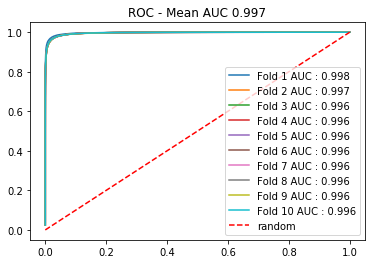

In [442]:
# Utilize SMOTE Upsampling method to handle imbalanced dataset
smot = SMOTE(kind='regular')
xsmote, ysmote = smot.fit_sample(Train_pca, Train_1.iloc[:,-1].values)
kfoldcvMethod(xsmote, ysmote)

# Output for upload

In [444]:
classifier = RandomForestClassifier(n_estimators = 100)
pred = classifier.fit(Train_pca,Train_1.iloc[:,-1].values).predict_proba(Test_pca)

In [453]:
df_out =  pd.DataFrame(pred[:,1],columns = ['target'])
print df_out.head()
print df_out.shape

   target
0    0.08
1    0.02
2    0.08
3    0.01
4    0.11
(892816, 1)


In [454]:
df_out['id'] = test_raw['id']

In [457]:
df_out = df_out[['id','target']]
print df_out.head()

   id  target
0   0    0.08
1   1    0.02
2   2    0.08
3   3    0.01
4   4    0.11


In [459]:
import datetime
dtstr = datetime.datetime.now()
df_out.to_csv('upload'+str(dtstr)+'.csv', header =True,index=False)